<a href="https://colab.research.google.com/github/KaroAntonio/climate-social-analysis/blob/main/notebooks/Climate_Conversation_Topic_Modelling_Process_and_Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Climate Conversation Topic Modelling - Process + Train
In this step of the analysis, we want to pre-process data for ingestion by the models.

1. Load and Prep Token Data
1. Conduct Feature Engineering
1. Prepare data for model ingestion

In [36]:
from google.colab import drive
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
from nltk import FreqDist
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
import gensim.downloader as api

drive.mount('/content/drive')
word2vec_model = api.load("word2vec-google-news-300")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
# Data paths
DRIVE_DIR = "/content/drive/MyDrive/Climate Social Analysis/data/"
PREPROCESSED_TOKENS_PATH = f"{DRIVE_DIR}topic_modelling_preprocessed_tokens_1m.csv"
TWEET_EMBEDDINGS_PATH = f"{DRIVE_DIR}topic_modelling_tweet_embeddings_1m.csv"
TWEET_PCA_FEATURES_PATH = f"{DRIVE_DIR}topic_modelling_tweet_pca_features_1m.csv"
WORD_VECTOR_SUBSET_PATH = f"{DRIVE_DIR}topic_modelling_word_vector_subset.csv"

In [4]:
# Load Token Strs
tokens_str_df = pd.read_csv(PREPROCESSED_TOKENS_PATH, index_col='id')

In [5]:
tokens_sr = tokens_str_df['processed_tokens_str'].apply(lambda x: x.split())

In [6]:
# Build Tweet Vectors
wv = word2vec_model
# Remove tokens not in Word Embeddings
filtered_tokens_sr = tokens_sr.apply(lambda tokens: [t for t in tokens if t in wv])
filtered_tokens_sr = filtered_tokens_sr[filtered_tokens_sr.apply(len) != 0]

tweet_vs_sr = filtered_tokens_sr.apply(lambda ts: wv[ts].mean(axis=0))
# Cast vectors to numpy
tweet_vs_ar = np.array(tweet_vs_sr.tolist())

In [33]:
# Let's build our vocabulary
token_counts = filtered_tokens_sr.explode().value_counts()
token_counts.head(10)

climate    722189
change     714414
global     344310
warming    328640
action      53881
u           45469
world       41266
ha          38570
say         38223
people      38062
Name: processed_tokens_str, dtype: int64

In [8]:
# Token_idx_lookup
token_idx_lookup = {token: idx for idx, token in enumerate(token_counts.index)}

### Feature Engineering

In [9]:
# Let's explore a A One-hot vector for each tweet
# that encodes if a tweet contains a token for each of the N most common tokens
# This might be a useful feature vector since it would be a sort of simplified
# word embedding with better interpretability
# weight specific tokens
TOP_N = 1000
most_common_tokens = token_counts.head(TOP_N).index.to_list()
common_tokens_vec_df = filtered_tokens_sr.apply(lambda tokens: [1 if t in tokens else 0 for t in most_common_tokens])

In [10]:
# Convert common token vec to a numpy array
common_tokens_vec_ar = np.array(common_tokens_vec_df.tolist())

In [12]:
# Now that we have a 1000 sparse vec representation for each tweet,
# we want to condense this representation to a lower dimensionality,
# 100 ish would be great
# How many unique rows are there?
# ~80% of rows are unique which means we would'nt gain much from bucketing
FreqDist(np.unique(common_tokens_vec_ar[:100000], axis=0, return_counts=True)[1])

FreqDist({1: 79287, 2: 2730, 3: 883, 4: 452, 5: 258, 6: 144, 7: 101, 8: 53, 10: 42, 9: 38, ...})

In [25]:
# Let's use PCA to reduce dims
# Using PCA gives us the advanctage of explainability when trying to determine
# which tokens impact a cluster most
# We want a number of components that explains a high cumulative amount of var
X = common_tokens_vec_ar
pca = PCA(n_components=300)
principal_components = pca.fit_transform(X[])

In [26]:
# So here we have a PCA vec that captures
# a tweets inclusion of the 1000 most common tokens
tokens_common_pca_ar = principal_components

In [27]:
# What are the linear coeffs of PC1?
# how signficiant are the first 4 tokens? (climate, change, global, warming)
# Signficiant are the loadings of the first for tokens for all components?
# A: Considering that the mean and stds of the loadings,
# the first 4 tokens appear not to be given significant weight,
# which is a good signal as know those tokens to 'drown out' the others
# Overview statistics
min_val = pca.components_.min()
max_val = pca.components_.max()
mean_val = pca.components_.mean()
std_val = pca.components_.std()
# Print overview statistics
print("Minimum:", min_val)
print("Maximum:", max_val)
print("Mean:", mean_val)
print("Standard deviation:", std_val)
print(pca.components_[:10,:4])

Minimum: -0.7511190651021763
Maximum: 0.8757923234990838
Mean: 0.0007215122838407995
Standard deviation: 0.031614544438031474
[[-0.48125373 -0.49076473  0.50994712  0.51191733]
 [ 0.03603486  0.02664644  0.09603283  0.04995252]
 [-0.1211036  -0.10143978 -0.11631866 -0.07595481]
 [ 0.50064891  0.44346556  0.53752346  0.36130444]
 [-0.00342118  0.00381931 -0.00492884  0.00112676]
 [-0.092722   -0.08948125 -0.09017257 -0.0646134 ]
 [-0.06835681 -0.07285857 -0.08218979 -0.0429577 ]
 [-0.02098205 -0.03151732 -0.03292789 -0.01033306]
 [-0.01272664 -0.01379502 -0.00104575 -0.00584636]
 [ 0.00982165  0.01256887  0.00550093  0.00564071]]


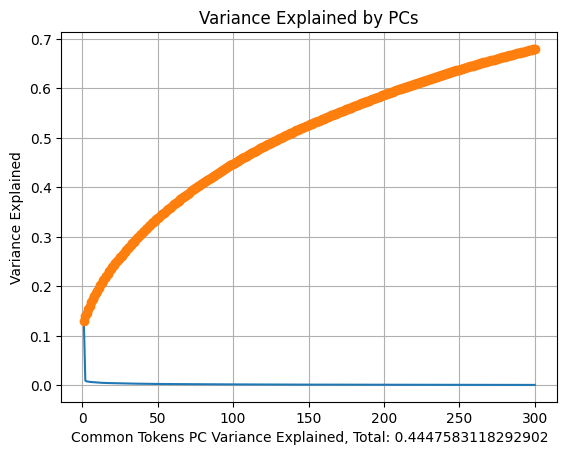

In [28]:
# Make a skree plot of the varianced explained
# Interesting, It looks like the variance is 0.13 for PC1 and <0.01 for the rest
# This implies PC1 is most useful by far
# However, it also is a concern in terms of how useful the other PCs are
# It's possible PCA had a difficulty with the sparseness of the original vecs
pca_variance_ratios = pca.explained_variance_ratio_
varience_cumsum = np.cumsum(pca_variance_ratios)
plt.plot(range(1, len(pca_variance_ratios) + 1), pca_variance_ratios, linestyle='-')
plt.plot(range(1, len(pca_variance_ratios) + 1), varience_cumsum, marker='o')
plt.xlabel(f'Common Tokens PC Variance Explained, Total: {total_varience_explained}')
plt.ylabel('Variance Explained')
plt.title('Variance Explained by PCs')
plt.grid(True)
plt.show()

In [29]:
# Let's make some naive cats to color the PCA scatter plots by
# this vec gives the least common category for each tweet
# use the top 10 most common words as cats
# ie, most common='climate' with idx=0
top_tokens = ['climate','warming','people','trump','scientist','environment','energy','world']
top_idxs = [token_idx_lookup[t] for t in top_tokens]
def categorize(row):
  cat_idxs = np.argwhere(row==1)
  if len(cat_idxs) == 0:
    return -1
  return cat_idxs.max()

max_category_ar = np.array([categorize(row) for row in common_tokens_vec_ar[:,top_idxs]])

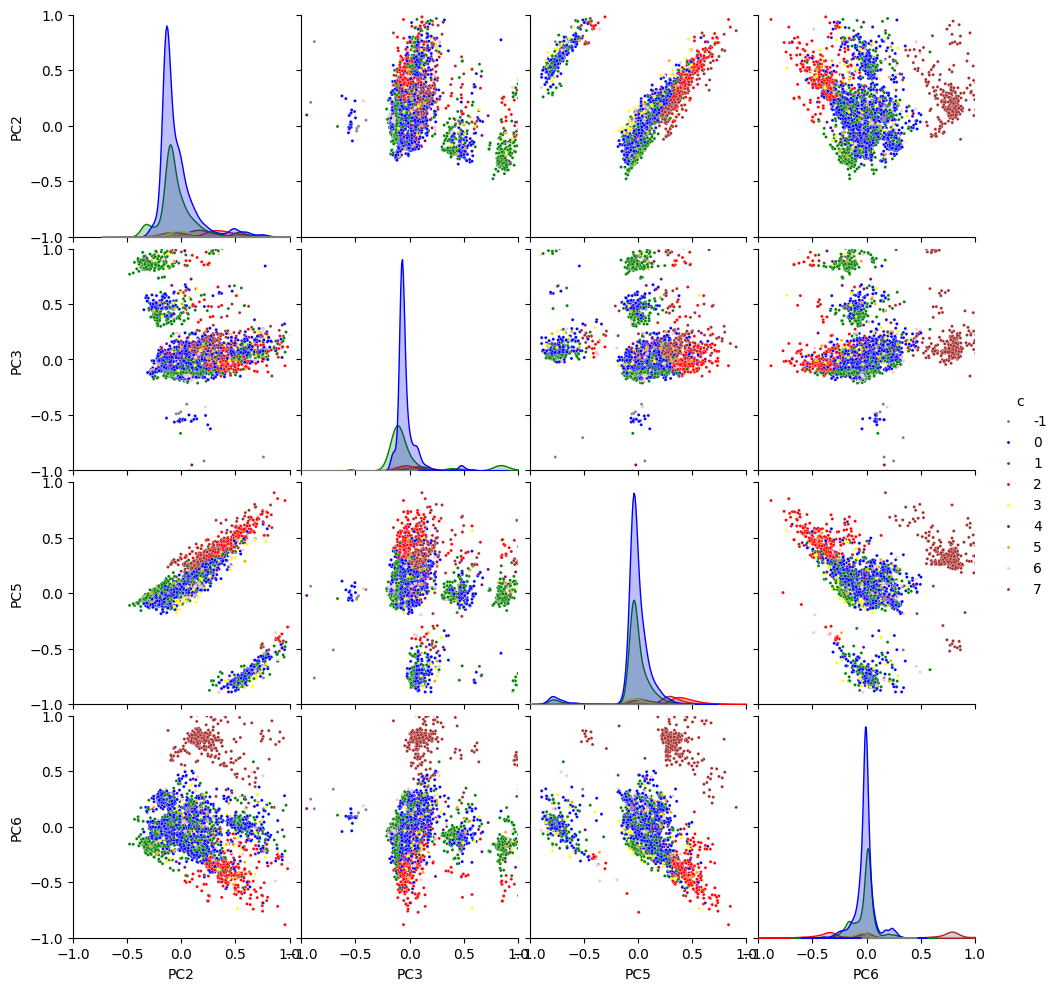

In [35]:
# Let's plot the first 3 PCs of the engineered common token pcs
# This should help us visualize if these PCs would be useful for clustering
# Plotting this including: climate, change, global, warming results in very linearly clumped graphs
# this might suggest removing all these tokens
# POSSIBLE ISSUE: There are several sub-clusters created by this approach
# I'm guessing this comes from the discrete nature of the 1 hot representation.

# Get a random sample of the points, the cloud is too dense to see structure otherwise
sample_size = 10000
indices = np.random.choice(principal_components.shape[0], sample_size, replace=False)
# Sample rows from the array using the indices
sampled_rows = principal_components[indices]

pc3 = sampled_rows[:, 2]
pc4 = sampled_rows[:, 3]
pc5 = sampled_rows[:, 4]
pc6 = sampled_rows[:, 5]

c = max_category_ar[indices]

# Create a DataFrame from the principal components
df = pd.DataFrame({'PC2': pc3, 'PC3': pc4, 'PC5': pc5,'PC6': pc6, 'c': c})

# cats = ['climate','warming','people','trump','scientist','environment','energy','world']
# colors for naive cats
custom_palette = {
    -1: 'grey', # None
    0: 'blue', # climate
    1: 'green', # warming
    2: 'red', # people
    3: 'yellow', # trump
    4: 'purple', # scientist
    5: 'orange', # environment
    6: 'pink', # energy
    7: 'brown', # world
}

# Create a pairplot of the principal components
pair_plot = sns.pairplot(df, hue='c', palette=custom_palette, plot_kws={'s': 5})
# Manually set the same limits for all axes
for ax in pair_plot.axes.flatten():
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
plt.show()

In [37]:
# Let's try TSVD for dim reducation of the sparse common tokens vecs
X = common_tokens_vec_ar
tsvd = TruncatedSVD(n_components=100)  # Specify the number of components
X_reduced = tsvd.fit_transform(X)

In [40]:
# How does the Cumulative Explained Variance metric look?
# It's roughly the same as the PCA approach

explained_variance_ratio = tsvd.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Print or plot the cumulative explained variance
print(f"Cumulative Explained Variance for 100 components: {cumulative_explained_variance[-1]}")

Cumulative Explained Variance for 100 components: 0.44641201884489873


## Clean up Features and Save for Modelling

In [51]:
# Export Tweet Embeddings
tweet_embeddings_df = pd.DataFrame(tweet_vs_ar, index = tweet_vs_sr.index)
print(tweet_embeddings_df.shape)
tweet_embeddings_df.to_csv(TWEET_EMBEDDINGS_PATH)

(999900, 300)


In [54]:
# Export Constructed PCA Features
print(principal_components.shape)
tweet_pca_features_df = pd.DataFrame(principal_components, index = tweet_vs_sr.index)
tweet_pca_features_df.to_csv(TWEET_PCA_FEATURES_PATH)

(999900, 300)


In [62]:
# Export The Subset of relevant Word Vectors For easier reference
word_vector_subset = [wv[t] for t in token_counts]
word_vector_subset = np.array(word_vector_subset)
word_vector_subset_df = pd.DataFrame(word_vector_subset, index = token_counts.index)
word_vector_subset_df.to_csv(WORD_VECTOR_SUBSET_PATH)